In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Ajuste de distribuciones con kernel density estimation y Python

> Método para encontrar la distribución no paramétrica que mejor se ajusta a los datos.

## Introducción

Identificar el tipo de distribución que tiene a una variable es un paso fundamental en prácticamente todos los estudios que implican datos, desde los contrastes de hipótesis hasta la creación de modelos por aprendizaje estadístico y machine learning. Son muchas las ventajas que tiene disponer de una función que describa aproximadamente los datos. Por ejemplo, se puede calcular la probabilidad (o densidad en el caso de variables aleatorias continuas) de que una observación tome un determinado valor. También es posible simular nuevos valores.

En términos generales, ajustar una distribución consiste en encontrar una función matemática capaz de describir un conjunto de datos. De entre todas las posibles funciones candidatas, lo interesante es encontrar aquella que, con mayor probabilidad, puede haber generado los datos observados.

Una de las aproximaciones más prácticas es utilizar como candidatas distribuciones paramétricas, estas son distribuciones conocidas cuyo comportamiento está determinado usando un número finito de parámetros. Por ejemplo, la distribución normal está parametrizada por la media y la desviación típica. Ver más sobre este tipo de ajustes en Ajuste y selección de distribuciones con Python.

Cuando ninguna de las distribuciones paramétricas disponibles describe correctamente los datos, es necesario recurrir lo que se conoce como métodos de ajuste no paramétricos, cuyo objetivo es encontrar funciones que describan distribuciones cualesquiera, entendiendo por cualesquiera a que no se limitan a las distribuciones paramétricas conocidas $^{nota}$. Uno de los métodos más empleados es kernel density estimation (KDE).

En Python existen varias librerías que permiten ajustar distribuciones mediante KDE:

- SciPy: `gaussian_kde.`

- Statsmodels: `KDEUnivariate y KDEMultivariate.`

- Scikit-learn: `KernelDensity.`

A lo largo de este documento se describen los fundamentos teóricos del método KDE y ejemplos de cómo utilizar la implementación de Scikit-learn.

Nota: el término distribución no paramétrica puede llevar a confusión. Estas distribuciones sí tienen parámetros, solo que no están predefinidos o acotados como en las funciones paramétricas.

## kernel density estimation (KDE)

En estadística, kernel density estimation (KDE), es un método no paramétrico que permite estimar la función de densidad de probabilidad de una variable aleatoria a partir de un número finito de observaciones (muestra). Fué propuesto por Fix y Hodges (1951) y Rosenblatt (1956).

Dado un valor ${x_i}$ la función aprendida por el kernel density estimator devuelve la densidad de la distribución en el punto ${x_i}.$ Esta densidad, cuyo valor está acotado al rango $[0, +\infty],$ es una medida relativa de verosimilitud (likelihood). Si la densidad para el punto A es mayor que la de B, significa que la probabilidad de que A pertenezca a la distribución es mayor que la de B. Con frecuencia, para facilitar los cálculos, en lugar de utilizar el valor de densidad se utiliza el su logaritmo, aun así, la interpretación es la misma, cuanto mayor su valor, mayor la evidencia de que la observación pertenece a la distribución.

### Histograma

Una forma de entender cómo funciona un kernel density estimation _(KDE)_ es partiendo del histograma. El histograma es una de las formas más utilizadas en estadística para representar la distribución de datos unidimensionales. Para su creación:

1. Se identifica el rango de valores observados, del más pequeño al más grande.

2. Se divide ese rango en intervalos de igual tamaño _(bins)_.

3. Se cuenta el número de observaciones que caen en cada intervalo.

4. Se representa una barra para cada intervalo cuya altura es proporcional al número de observaciones que han caído en él.

5. Opcionalmente, normalizar la altura de las barras para que el área total sea uno. En este caso, en lugar de cuentas, el eje ${y}$ representa la densidad de probabilidad.

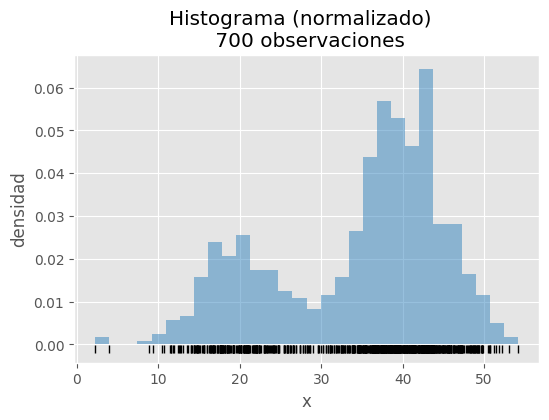

In [3]:
# Ejemplo histograma distribución bimodal
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

muestra_1 = np.random.normal(loc=20, scale=5, size=200)
muestra_2 = np.random.normal(loc=40, scale=5, size=500)
datos = np.hstack((muestra_1, muestra_2))

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
ax.set_title("Histograma (normalizado)  \n 700 observaciones")
ax.set_xlabel("x")
ax.set_ylabel("densidad")
plt.show()

El principal inconveniente de los histogramas es que dependen en gran medida del número de intervalos _(bins)_ que se utilicen, y de que la distribución generada es escalonada en lugar de continua. Este efecto se hace más evidente cuando hay pocas observaciones.

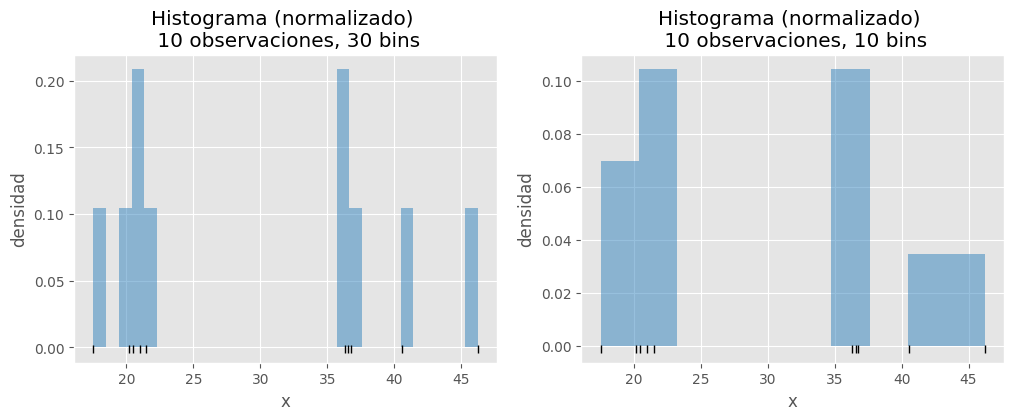

In [4]:
# Ejemplo histograma distribución bimodal pocas observaciones
# ==============================================================================

muestra_1 = np.random.normal(loc=20, scale=5, size=5)
muestra_2 = np.random.normal(loc=40, scale=5, size=5)
datos = np.hstack((muestra_1, muestra_2))

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
axs[0].hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5)
axs[0].plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
axs[0].set_title("Histograma (normalizado) \n 10 observaciones, 30 bins")
axs[0].set_xlabel("x")
axs[0].set_ylabel("densidad")

axs[1].hist(datos, bins=10, density=True, color="#3182bd", alpha=0.5)
axs[1].plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
axs[1].set_title("Histograma (normalizado) \n 10 observaciones, 10 bins")
axs[1].set_xlabel("x")
axs[1].set_ylabel("densidad")
plt.show()

Con solo 10 observaciones, incluso con diferente número de bins, es difícil que el histograma consiga una aproximación adecuada a la distribución real de la que proceden los datos.

## Creación de un KDE

### Idea intuitiva

kernel density estimation (KDE) expande la idea del histograma, "cada observación aumenta la densidad de probabilidad en la zona donde se encuentra", pero lo hace de forma que las contribuciones se agrupen creando una curva continua y suave (smooth). ¿Cómo lo consigue?

Supóngase que se dispone de un conjunto de observaciones ${X:}$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

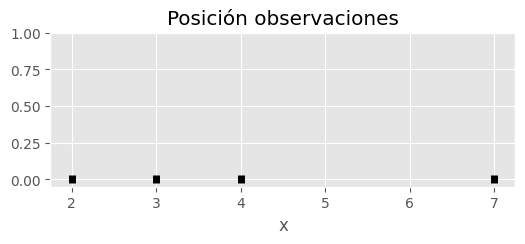

In [6]:
X = np.array([2, 3, 4, 7])
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(X, np.full_like(X, 0.05), "|k", markeredgewidth=5)
ax.set_ylim(-0.05, 1)
ax.set_title("Posición observaciones")
ax.set_xlabel("x")
ax.set_ylabel("")
plt.show()

A continuación, sobre cada observación se centra una distribución normal, con media igual al valor de la observación y desviación típica de 1 (más adelante se detalla la elección de este valor).

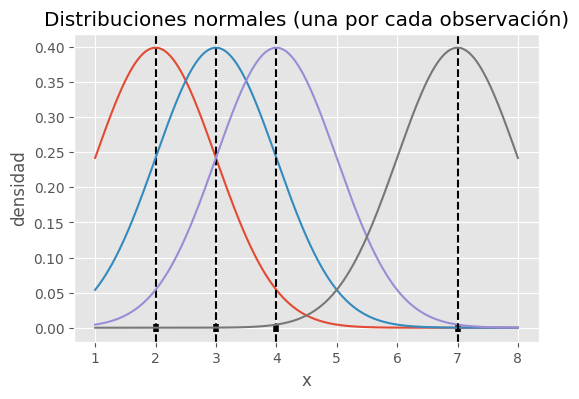

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X, np.full_like(X, 0), "|k", markeredgewidth=4)

Xgrid = np.linspace(min(X) - 1, max(X) + 1, num=500)

for x in X:
    densidad = stats.norm.pdf(Xgrid, loc=x, scale=1)
    ax.axvline(x=x, linestyle="--", color="black")
    ax.plot(Xgrid, densidad)

ax.set_title("Distribuciones normales (una por cada observación)")
ax.set_xlabel("x")
ax.set_ylabel("densidad")
plt.show()

De esta forma se consigue que cada observación contribuya justo en la posición que ocupa pero también, de forma gradual, en las regiones cercanas.

Por último, si se suman las contribuciones individuales y se dividen por el total de curvas (observaciones), se consigue una curva final que describe la distribución de las observaciones.

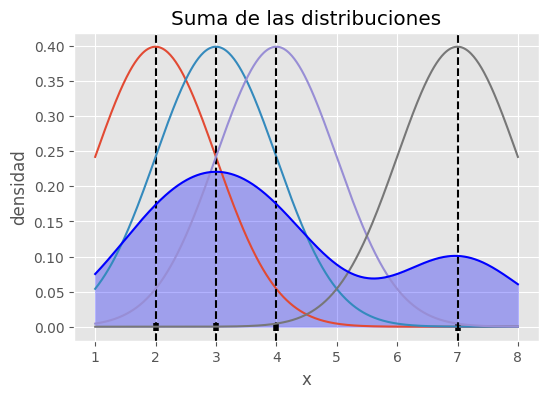

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X, np.full_like(X, 0), "|k", markeredgewidth=4)

Xgrid = np.linspace(min(X) - 1, max(X) + 1, num=500)

suma = np.full_like(Xgrid, 0)
for x in X:
    densidad = stats.norm.pdf(Xgrid, loc=x, scale=1)
    suma = suma + densidad
    ax.axvline(x=x, linestyle="--", color="black")
    ax.plot(Xgrid, densidad)

suma = suma / len(X)
ax.plot(Xgrid, suma, color="b")
ax.fill_between(Xgrid, suma, alpha=0.3, color="b")

ax.set_title("Suma de las distribuciones")
ax.set_xlabel("x")
ax.set_ylabel("densidad")

Esta idea tan sencilla pero a la vez tan potente es en la que se fundamenta el método _kernel density estimation (KDE)_: aproximar una función de densidad como la suma de funciones _(kernel)_ de cada observación.

### Definición matemática

Dado un conjunto de datos ${}$, la función de distribución de densidad ${}$ peude aproximarse utilizando un kernel density estimation (KDE) tal que:
$${\hat{f}(x) = \frac{1}{n}\sum_{i=1}^{n}K_h(x-x_i) = \frac{1}{nh}\sum_{i=1}^{n}K(\frac{x-x_{i}}{h})}$$

- ${n}:$ es el número de datos (observaciones). Cada uno de ellos es el centro sobre el que se coloca un kernel.

- ${h}:$ es el ancho de banda (bandwidth o smoothing parameter). Controla cuánto se expande la influencia de cada observación. Si se emplea como kernel una distribución normal, equivale a la desviación típica. Este es el valor más determinante a la hora de ajustar un KDE, puesto que condiciona el nivel de sobreajuste.

- ${K}:$ es el Kernel, una función que define la forma y la distribución de la influencia (peso) que se asocian a cada observación. En los ejemplos anteriores se ha utilizado como kernel la distribución normal.

### Selección del ancho de banda

El ancho de banda es crucial a la hora de estimar una función densidad mediante el método KDE. Si su valor es muy bajo, se genera overfitting y la función resultante estará demasiado influenciada por el "ruido" de los datos. Si su valor es muy elevado, la función resultante no será capaz de aprender la distribución subyacente.

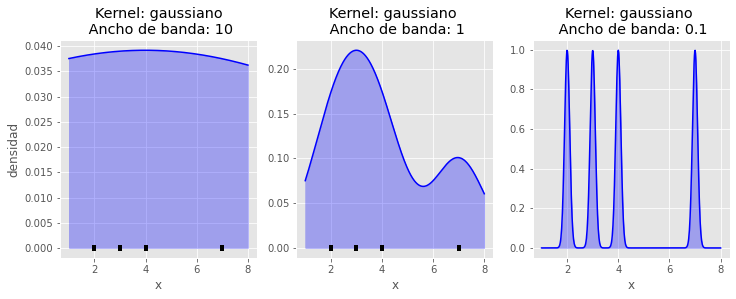

Aunque no hay forma de saber de antemano cuál es el valor óptimo del ancho de banda, existen varias estrategias para identificar buenos valores.

**Reglas empíricas**

- Scott’s rule: ${h \approx 1.06 \cdot \hat{\sigma} n^{-1/5}}$

- Silverman’s rule: ${h = 0.9 \cdot \min ( \hat{\sigma}, IQR/1.35 ) n^{-1/5}}$

Si bien estos métodos son muy rápidos, tienen el limitante de funcionar bien solo cuando la función de densidad real es aproximadamente normal.

**Validación cruzada**

Requiere de mayor tiempo de computación pero es útil para cualquier tipo de distribución. Validación cruzada es la opción disponible en Scikit learn, utilizando como métrica de comparación en log-likelihood.

Es importante destacar que, cuando se dispone de pocos datos, conviene utilizar one leave out crossvalidation.

### Tipo de kernel

El kernel es la función que determina cómo se distribuye la influencia de cada observación, por lo tanto, puede tener un impacto notable en la estimación de la función de densidad resultante. Aunque en la gran mayoría de casos se emplea un kernel gaussiano (distribución normal), existen otras posibilidades. Las implementadas en scikit learn son:

- Gaussian: asigna los pesos siguiendo la distribución normal con una desviación estándar equivalente al ancho de banda. $${K(x; h) \propto \exp(- \frac{x^2}{2h^2} )}$$

- Epanechnikov: las observaciones que están a una distancia entre 0 y h tienen un peso entre ${\frac{3}{4} y 0}$ con disminución cuadrática. Toda observación fuera de este rango tiene pero 0. $${K(x; h) \propto 1 - \frac{x^2}{h^2}}$$

- Tophat: Asigna el mismo peso a todas las observaciones que estén dentro del ancho de banda. $${K(x; h) \propto 1 \text{ si } x < h}$$

- Exponential: el peso decae de forma exponencial. $${K(x; h) \propto \exp(-x/h)}$$

- Linear: el peso decae de forma lineal dentro del ancho de banda. Más allá de este el pero es 0. $${K(x; h) \propto 1 - x/h \text{ si } x < h}$$

- Cosine: el peso dentro del ancho de banda es proporcional al coseno. $${K(x; h) \propto \cos(\frac{\pi x}{2h}) \text{ si } x < h}$$

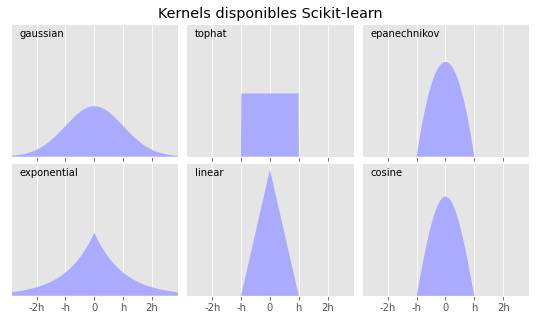

## Ejemplo univariante

En el siguiente ejemplo se utiliza el método kernel density estimation (KDE) para tratar de ajustar la función de densidad de unos datos simulados a partir de una distribución normal bimodal (solapamiento de dos distribuciones normales).

### Librerías

Las librerías utilizadas en este documento son:

In [9]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style

# Ajuste de distribuciones
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Ignorar warnings
import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)

### Datos

Para esta demostración, se emplean datos simulados a partir de una distribución mixta formada por dos distribuciones normales:

- Distribución 1: ${\mathcal{N}(1,\,0.5)}$, peso 0.25

- Distribución 1: ${}$ peso 0.75

Los pesos indican la proporción en que cada distribución individual contribuye a la distribución final.

In [10]:
# Datos
# ==============================================================================
n = 1000
np.random.seed(123)
muestra_1 = np.random.normal(loc=1, scale=0.5, size=int(n * 0.75))
muestra_2 = np.random.normal(loc=-1, scale=0.5, size=int(n * 0.25))
datos = np.hstack((muestra_1, muestra_2))

Como los datos han sido simulados, se puede calccular la verdadera curva de densidad.

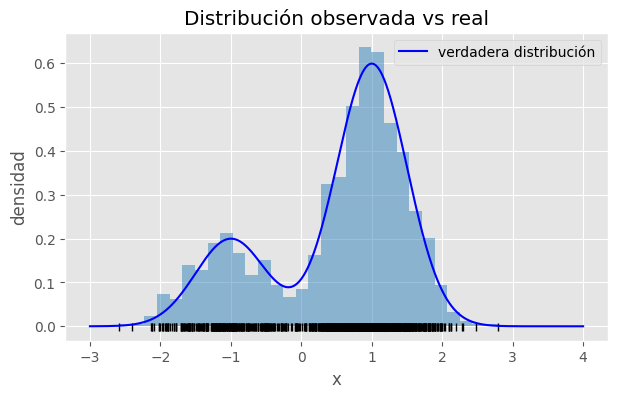

In [11]:
# Superposición de histograma con la verdadera distribución
# ==============================================================================
X_grid = np.linspace(-3, 4, 1000)
densidad = (
    stats.norm.pdf(loc=1, scale=0.5, x=X_grid) * 0.75
    + stats.norm.pdf(loc=-1, scale=0.5, x=X_grid) * 0.25
)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
ax.plot(X_grid, densidad, color="blue", label="verdadera distribución")
ax.set_title("Distribución observada vs real")
ax.set_xlabel("x")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

### Modelo KDE

La clase `KernelDensity` de **Scikit learn** implementa el algoritmo para estimar la función de densidad de distribuciones univariantes y multivariantes.

En primer lugar, se entrena un modelo utilizo un kernandel lineal y un ancho de banda (bandwidth) de 1.

In [12]:
# Ajuste del modelo KDE
# ==============================================================================
modelo_kde = KernelDensity(kernel="linear", bandwidth=1)
modelo_kde.fit(X=datos.reshape(-1, 1))

KernelDensity(bandwidth=1, kernel='linear')

Una vez entrenado el modelo, con el método `score_samples()` se puede predecir la densidad estimada para cualquier nuevo valor. El valor devuelto está en escala logarítmica.

In [13]:
# Predicción de densidad
# ==============================================================================
new_X = np.array([1])
log_density_pred = modelo_kde.score_samples(X=new_X.reshape(-1, 1))
# Se aplica el exponente para deshacer el logaritmo
density_pred = np.exp(log_density_pred)
density_pred

array([0.46014262])

Si se calcula la predicción para todo el rango de valores observado, se puede representar la función de densidad obtenida.

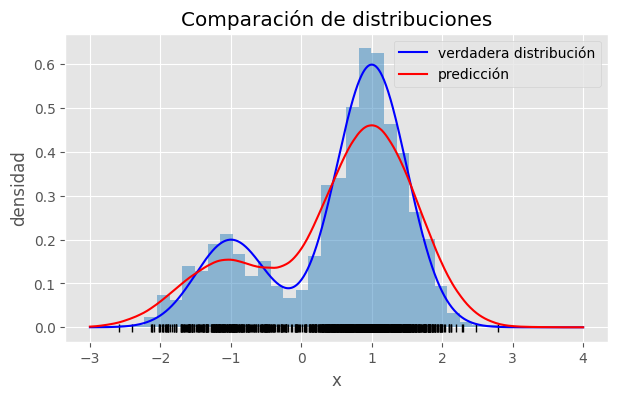

In [14]:
# Gráfico distribución de densidad estimada (predicción) vs real
# ==============================================================================
X_grid = np.linspace(-3, 4, 1000)
densidad_real = (
    stats.norm.pdf(loc=1, scale=0.5, x=X_grid) * 0.75
    + stats.norm.pdf(loc=-1, scale=0.5, x=X_grid) * 0.25
)

log_densidad_pred = modelo_kde.score_samples(X_grid.reshape((-1, 1)))
# Se aplica el exponente para deshacer el logaritmo
densidad_pred = np.exp(log_densidad_pred)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
ax.plot(X_grid, densidad_real, color="blue", label="verdadera distribución")
ax.plot(X_grid, densidad_pred, color="red", label="predicción")
ax.set_title("Comparación de distribuciones")
ax.set_xlabel("x")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

### Selección de kernel y bandwidth

El tipo de kernel y bandwidth son hiperparámetros cuyo valor óptimo no puede conocerse de antemano. Se emplea validación cruzada para tratar de identificar la combinación que consigue mejores resultados.


In [15]:
# Validación cruzada para identificar kernel y bandwidth
# ==============================================================================

param_grid = {
    "kernel": ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"],
    "bandwidth": np.linspace(0.01, 3, 10),
}

grid = GridSearchCV(
    estimator=KernelDensity(), param_grid=param_grid, n_jobs=-1, cv=10, verbose=0
)

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X=datos.reshape((-1, 1)))

In [16]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_kde_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'bandwidth': 0.34222222222222226, 'kernel': 'epanechnikov'} : -136.0570751805882 None


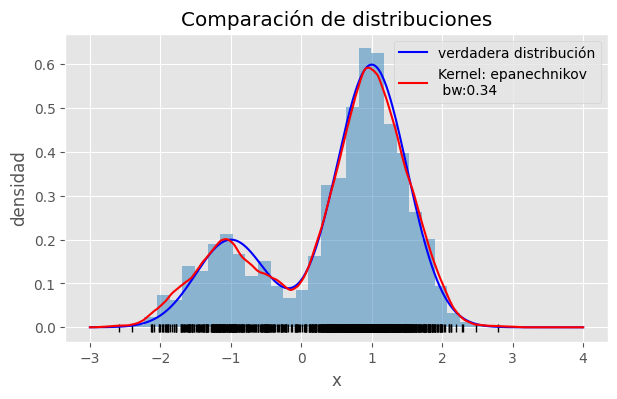

In [17]:
# Gráficos distribución de densidad modelo final
# ==============================================================================
X_grid = np.linspace(-3, 4, 1000)
densidad_real = (
    stats.norm.pdf(loc=1, scale=0.5, x=X_grid) * 0.75
    + stats.norm.pdf(loc=-1, scale=0.5, x=X_grid) * 0.25
)

log_densidad_pred = modelo_kde_final.score_samples(X_grid.reshape((-1, 1)))
# Se aplica el exponente para deshacer el logaritmo
densidad_pred = np.exp(log_densidad_pred)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
ax.plot(X_grid, densidad_real, color="blue", label="verdadera distribución")
ax.plot(X_grid, densidad_pred, color="red", label="Kernel: epanechnikov \n bw:0.34")
ax.set_title("Comparación de distribuciones")
ax.set_xlabel("x")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

La función de densidad obtenida empleando un kernel de **epanechnikov** con un ancho de banda de **0.34** consigue aproximarse bien a la distribución real.

Cabe recordar que esta comparación solo es posible porque los datos han sido simulados. En la práctica, no se suele conocer la verdadera distribución, de lo contrario no se necesitaría aplicar una aproximación _KDE_.

## Ejemplo multivariante

odo lo explicado sobre el ajuste mediante kernel density estimation (KDE) aplica a distribuciones de más de una dimensión (multivariante). Sin embargo, es importante tener en cuenta que, debido al problema conocido como curse of dimensionality, los resultados empeoran exponencialmente a medida que se aumenta el número de variables.

### Librerías

In [18]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style

# Ajuste de distribuciones
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# Ignorar warnings
import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)

### Datos

El set de datos geyser del paquete de **R** `MASS`, contiene información sobre las erupciones del géiser Old Faithful localizado en el parque nacional de Yellowstone, Wyoming. En concreto, recoge información sobre la duración de 299 erupciones, así como el intervalo de tiempo transcurrido entre ellas.

In [19]:
# Lectura de datos
# ==============================================================================
url = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
    + "Estadistica-machine-learning-python/master/data/geyser.csv"
)
datos = pd.read_csv(url)

In [20]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   waiting   299 non-null    int64  
 1   duration  299 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


In [21]:
datos.head()

,waiting,duration
0,80,4.016667
1,71,2.150000
2,57,4.000000
3,80,4.000000
4,75,4.000000


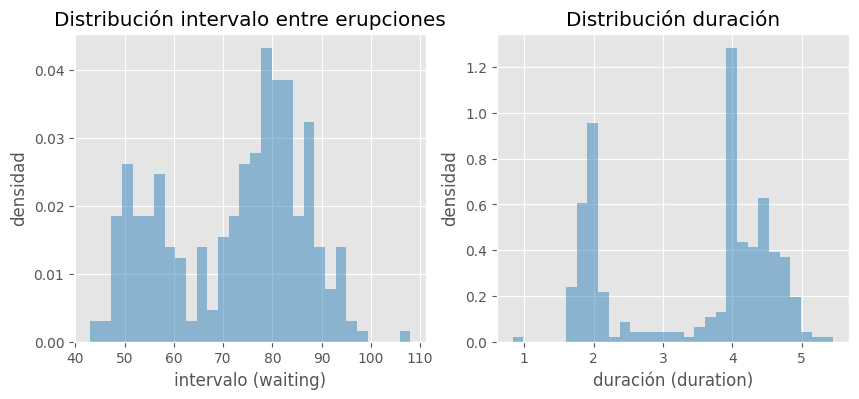

In [22]:
# Histograma de cada variable
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(datos.waiting, bins=30, density=True, color="#3182bd", alpha=0.5)
axs[0].set_title("Distribución intervalo entre erupciones")
axs[0].set_xlabel("intervalo (waiting)")
axs[0].set_ylabel("densidad")

axs[1].hist(datos.duration, bins=30, density=True, color="#3182bd", alpha=0.5)
axs[1].set_title("Distribución duración")
axs[1].set_xlabel("duración (duration)")
axs[1].set_ylabel("densidad")

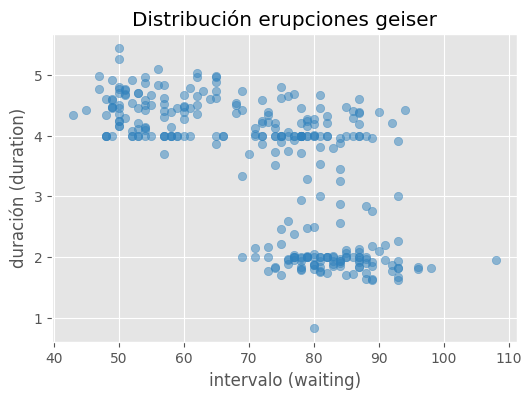

In [23]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.scatter(datos.waiting, datos.duration, color="#3182bd", alpha=0.5)
ax.set_title("Distribución erupciones geiser")
ax.set_xlabel("intervalo (waiting)")
ax.set_ylabel("duración (duration)")
plt.show()

### Modelo KDE

Se utiliza validación cruzada para identificar el mejor tipo de kernel y el ancho de banda. Al disponer de pocos datos, se emplea la estrategia **LeaveOneOut**.

In [24]:
# Validación cruzada para identificar kernel y bandwidth
# ==============================================================================

param_grid = {
    "kernel": ["gaussian", "epanechnikov"],
    "bandwidth": np.linspace(0.01, 3, 10),
}

grid = GridSearchCV(
    estimator=KernelDensity(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=LeaveOneOut(),
    verbose=0,
)

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X=datos)

In [25]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_kde = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'bandwidth': 1.0066666666666668, 'kernel': 'gaussian'} : -5.405507362732498 None


Si se calcula la predicción para todo el rango de valores observado, se puede representar la función de densidad obtenida. Al tratarse de dos dimensiones, hay que crear un grid que cubra toda la superficie.

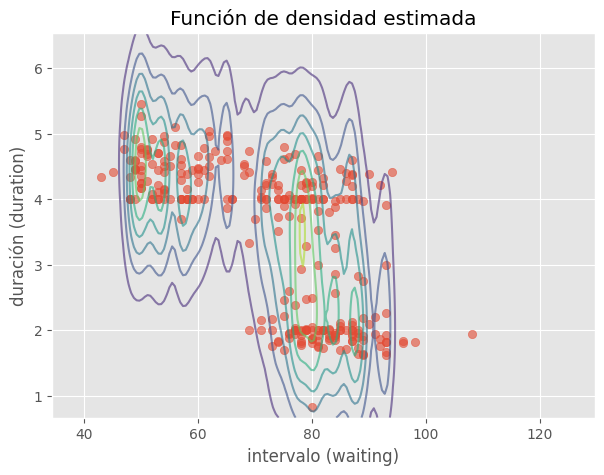

In [26]:
# Mapa de densidad de probabilidad
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Grid de valores dentro del rango observado (2 dimensiones)
x = np.linspace(min(datos.waiting) * 0.8, max(datos.waiting) * 1.2, 200)
y = np.linspace(min(datos.duration) * 0.8, max(datos.duration) * 1.2, 200)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack((xx.flatten(), yy.flatten()))

# Densidad de probabilidad de cada valor del grid
log_densidad_pred = modelo_kde.score_samples(grid)
densidad_pred = np.exp(log_densidad_pred)

ax.scatter(datos.waiting, datos.duration, alpha=0.6)
ax.contour(xx, yy, densidad_pred.reshape(xx.shape), alpha=0.6)
ax.set_title("Función de densidad estimada")
ax.set_xlabel("intervalo (waiting)")
ax.set_ylabel("duración (duration)")
plt.show()

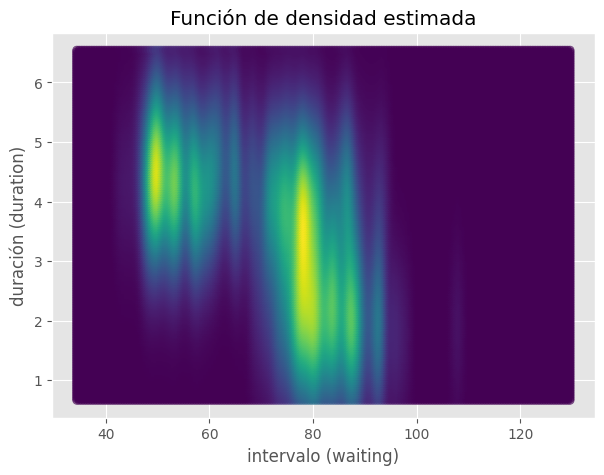

In [27]:
# Representación como mapa de calor
# ===============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax.scatter(grid[:, 0], grid[:, 1], alpha=0.6, c=densidad_pred)
ax.set_title("Función de densidad estimada")
ax.set_xlabel("intervalo (waiting)")
ax.set_ylabel("duración (duration)")
plt.show()

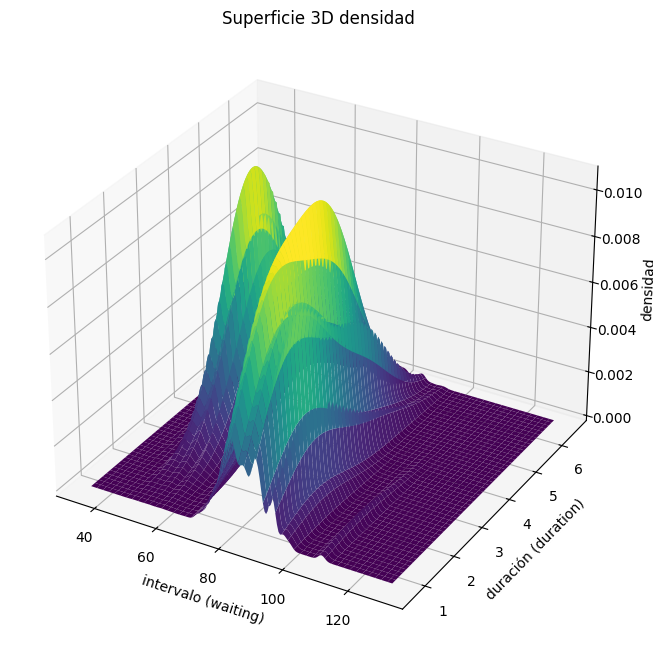

In [28]:
# Representación 3D
# ===============================================================================
from mpl_toolkits.mplot3d import axes3d

plt.style.use("default")
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
# ax.view_init(60, 35)
ax.plot_surface(xx, yy, densidad_pred.reshape(xx.shape), cmap="viridis")
ax.set_xlabel("intervalo (waiting)")
ax.set_ylabel("duración (duration)")
ax.set_zlabel("densidad")
ax.set_title("Superficie 3D densidad")
plt.show()
plt.style.use("ggplot")
plt.show()

### Predicción

Una vez estimada la función de densidad, se puede predecir su valor para cualquier otra observación.Por ejemplo, que una erupción tenga un intervalo de 120 y una duración de 1 (esquina inferior del gráfico 3D).

In [29]:
new_data = np.array([120, 1]).reshape(1, 2)
log_densidad_pred = modelo_kde.score(new_data)
densidad_pred = np.exp(log_densidad_pred)
densidad_pred

4.6835678838332887e-35

Entre los datos observados no hay ninguna erupción con estas características, de ahí que su valor de densidad sea muy bajo. De nuevo matizar que el valor obtenido es una densidad de probabilidad, no probabilidad, por lo que su rango está acotado entre [0 + ${\infty}$]

Este valor permite comparar cómo de verosímil es una observación frente a otra **en esta misma distribución**, es decir sirve para hacer comparaciones relativas